### Evaluating Jazz album prices on Discogs.com
### Data Analysis
- program: 03_analysis.ipynb
- purpose: readin clean .csv output from 02_dataprep 
- date: jan 17, 2021
- created by: chris chan
- Methods:
    - EDA
    - OLS
    - CV for Model Selection
    - Train, Val, Test data

### 1. Pre Processing

In [1015]:
import pandas as pd
import numpy as np
import seaborn as sns 

%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score


Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


**Read-in clean dataframe**

In [1094]:
df=pd.read_csv(r'../data/clean/_df_clean.csv')
df.head(3)

,Artist_Album,Label,Country,Format,Notes,Genre,Release_Date,Style,Media_Condition,Sleeve_Condition,...,album,reclabel,recyear,sleeve_cond_abbr,media_cond_abbr,seller_rating,rating,votes,haves,wants
0,Miles Davis – Volume 2,Blue Note – BLP 1502,US,"Vinyl, LP, Compilation, Remastered, Mono","Recorded at the WOR Studios, NYC, on May 9, 19...",Jazz,Feb 1956,"Hard Bop, Bop",Very Good Plus (VG+),Sleeve: Very Good (VG),...,Volume 2,Blue Note,56.0,VG,VG+,0.988,4.32,25.0,219.0,301.0
1,Curtis Fuller – The Opener,Blue Note – BLP 1567,US,"Vinyl, LP, Album, Mono","Recorded on June 16, 1957.",Jazz,1957,Hard Bop,Very Good (VG),Sleeve: Very Good (VG),...,The Opener,Blue Note,57.0,VG,VG,1.000,4.50,16.0,68.0,385.0
2,The Jazz Messengers* – At The Cafe Bohemia Vol...,Blue Note – BLP 1508,US,"Vinyl, LP, Album, Mono","Recorded live on November 23, 1955.\n\n1st ori...",Jazz,May 1956,Hard Bop,Near Mint (NM or M-),Sleeve: Very Good Plus (VG+),...,At The Cafe Bohemia Volume 2,Blue Note,56.0,VG+,NM or M-,0.988,4.62,29.0,206.0,411.0


In [902]:
df.shape

(4085, 34)

In [817]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4085 entries, 0 to 4084
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist_Album      4084 non-null   object 
 1   Label             4084 non-null   object 
 2   Country           4083 non-null   object 
 3   Format            4084 non-null   object 
 4   Notes             3807 non-null   object 
 5   Genre             4084 non-null   object 
 6   Release_Date      4084 non-null   object 
 7   Style             4084 non-null   object 
 8   Media_Condition   4084 non-null   object 
 9   Sleeve_Condition  4077 non-null   object 
 10  Seller_Rating     4070 non-null   object 
 11  Recorded_at       2077 non-null   object 
 12  Pressed_by        1252 non-null   object 
 13  Price             4084 non-null   object 
 14  notes             3807 non-null   object 
 15  fpress            4085 non-null   int64  
 16  spress            4085 non-null   int64  


**1b. Data Cleaning**
- We see Pressed and Recorded at are missing many values. Drop these columns as they are not useful
- Other columns to drop are redundant

In [1095]:
df.drop(['Price','Recorded_at','Pressed_by','Seller_Rating','Media_Condition','Sleeve_Condition','Artist_Album','Format'], axis=1, inplace=True)

In [1096]:
df.describe()

,fpress,spress,tpress,original,rare,dgroove,sealed,price,recyear,seller_rating,rating,votes,haves,wants
count,4085.000000,4085.000000,4085.000000,4085.000000,4085.000000,4085.000000,4085.000000,4084.000000,4084.000000,4070.000000,3887.000000,3887.000000,4084.000000,4084.000000
mean,0.250184,0.073929,0.092778,0.235496,0.070257,0.219829,0.068299,134.471663,62.141038,0.992149,4.439048,22.401338,188.975759,203.906464
std,0.433172,0.261687,0.290157,0.424360,0.255611,0.414181,0.252289,200.238919,3.842566,0.028489,0.381360,29.667977,252.136287,275.438284
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,52.000000,0.500000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,59.000000,0.994000,4.250000,5.000000,40.000000,58.750000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,62.000000,0.999000,4.500000,12.000000,95.000000,121.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,140.000000,65.000000,1.000000,4.670000,27.000000,231.250000,255.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000,70.000000,1.000000,5.000000,210.000000,1943.000000,3685.000000


**Cleaning Haves / Wants**
- there were very few zeros as haves and wants (<6 each)
- deciding to impute to 1 so we can perform non-zero functions

In [1097]:
haveszero = np.array(df['haves'].values.tolist())
df['haves'] = np.where(haveszero ==0 , 1, haveszero).tolist()

wantszero = np.array(df['wants'].values.tolist())
df['wants'] = np.where(wantszero ==0 , 1, wantszero).tolist()

**seller rating**
- Impute with mode

In [1098]:
df['seller_rating'].fillna(value=df['seller_rating'].mode(),inplace=True)

**DROPPING rows with NA**
- the remaining NAs are:
    - ratings
    - votes
    - sleeve condition
- these may be not worth imputing at this moment

In [496]:
# In case we want to impute
# df['rating'].fillna(value=df['rating'].mode(),inplace=True)
# df['votes'].fillna(value=df['votes'].mode(),inplace=True)

In [1099]:
#df.isnull().values.any()
df.isnull().sum().sum()

1138

In [1100]:
# Dropping NAN
df.dropna(inplace=True)

In [1101]:
df.shape

(3523, 26)

In [1102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3523 entries, 0 to 4084
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Label             3523 non-null   object 
 1   Country           3523 non-null   object 
 2   Notes             3523 non-null   object 
 3   Genre             3523 non-null   object 
 4   Release_Date      3523 non-null   object 
 5   Style             3523 non-null   object 
 6   notes             3523 non-null   object 
 7   fpress            3523 non-null   int64  
 8   spress            3523 non-null   int64  
 9   tpress            3523 non-null   int64  
 10  original          3523 non-null   int64  
 11  rare              3523 non-null   int64  
 12  dgroove           3523 non-null   int64  
 13  sealed            3523 non-null   int64  
 14  price             3523 non-null   float64
 15  artist            3523 non-null   object 
 16  album             3523 non-null   object 


**Pair Plot on numeric FULL DF**

In [1045]:
df_pair=df.drop(['fpress','spress','tpress','original','rare','sealed','dgroove'],axis=1)

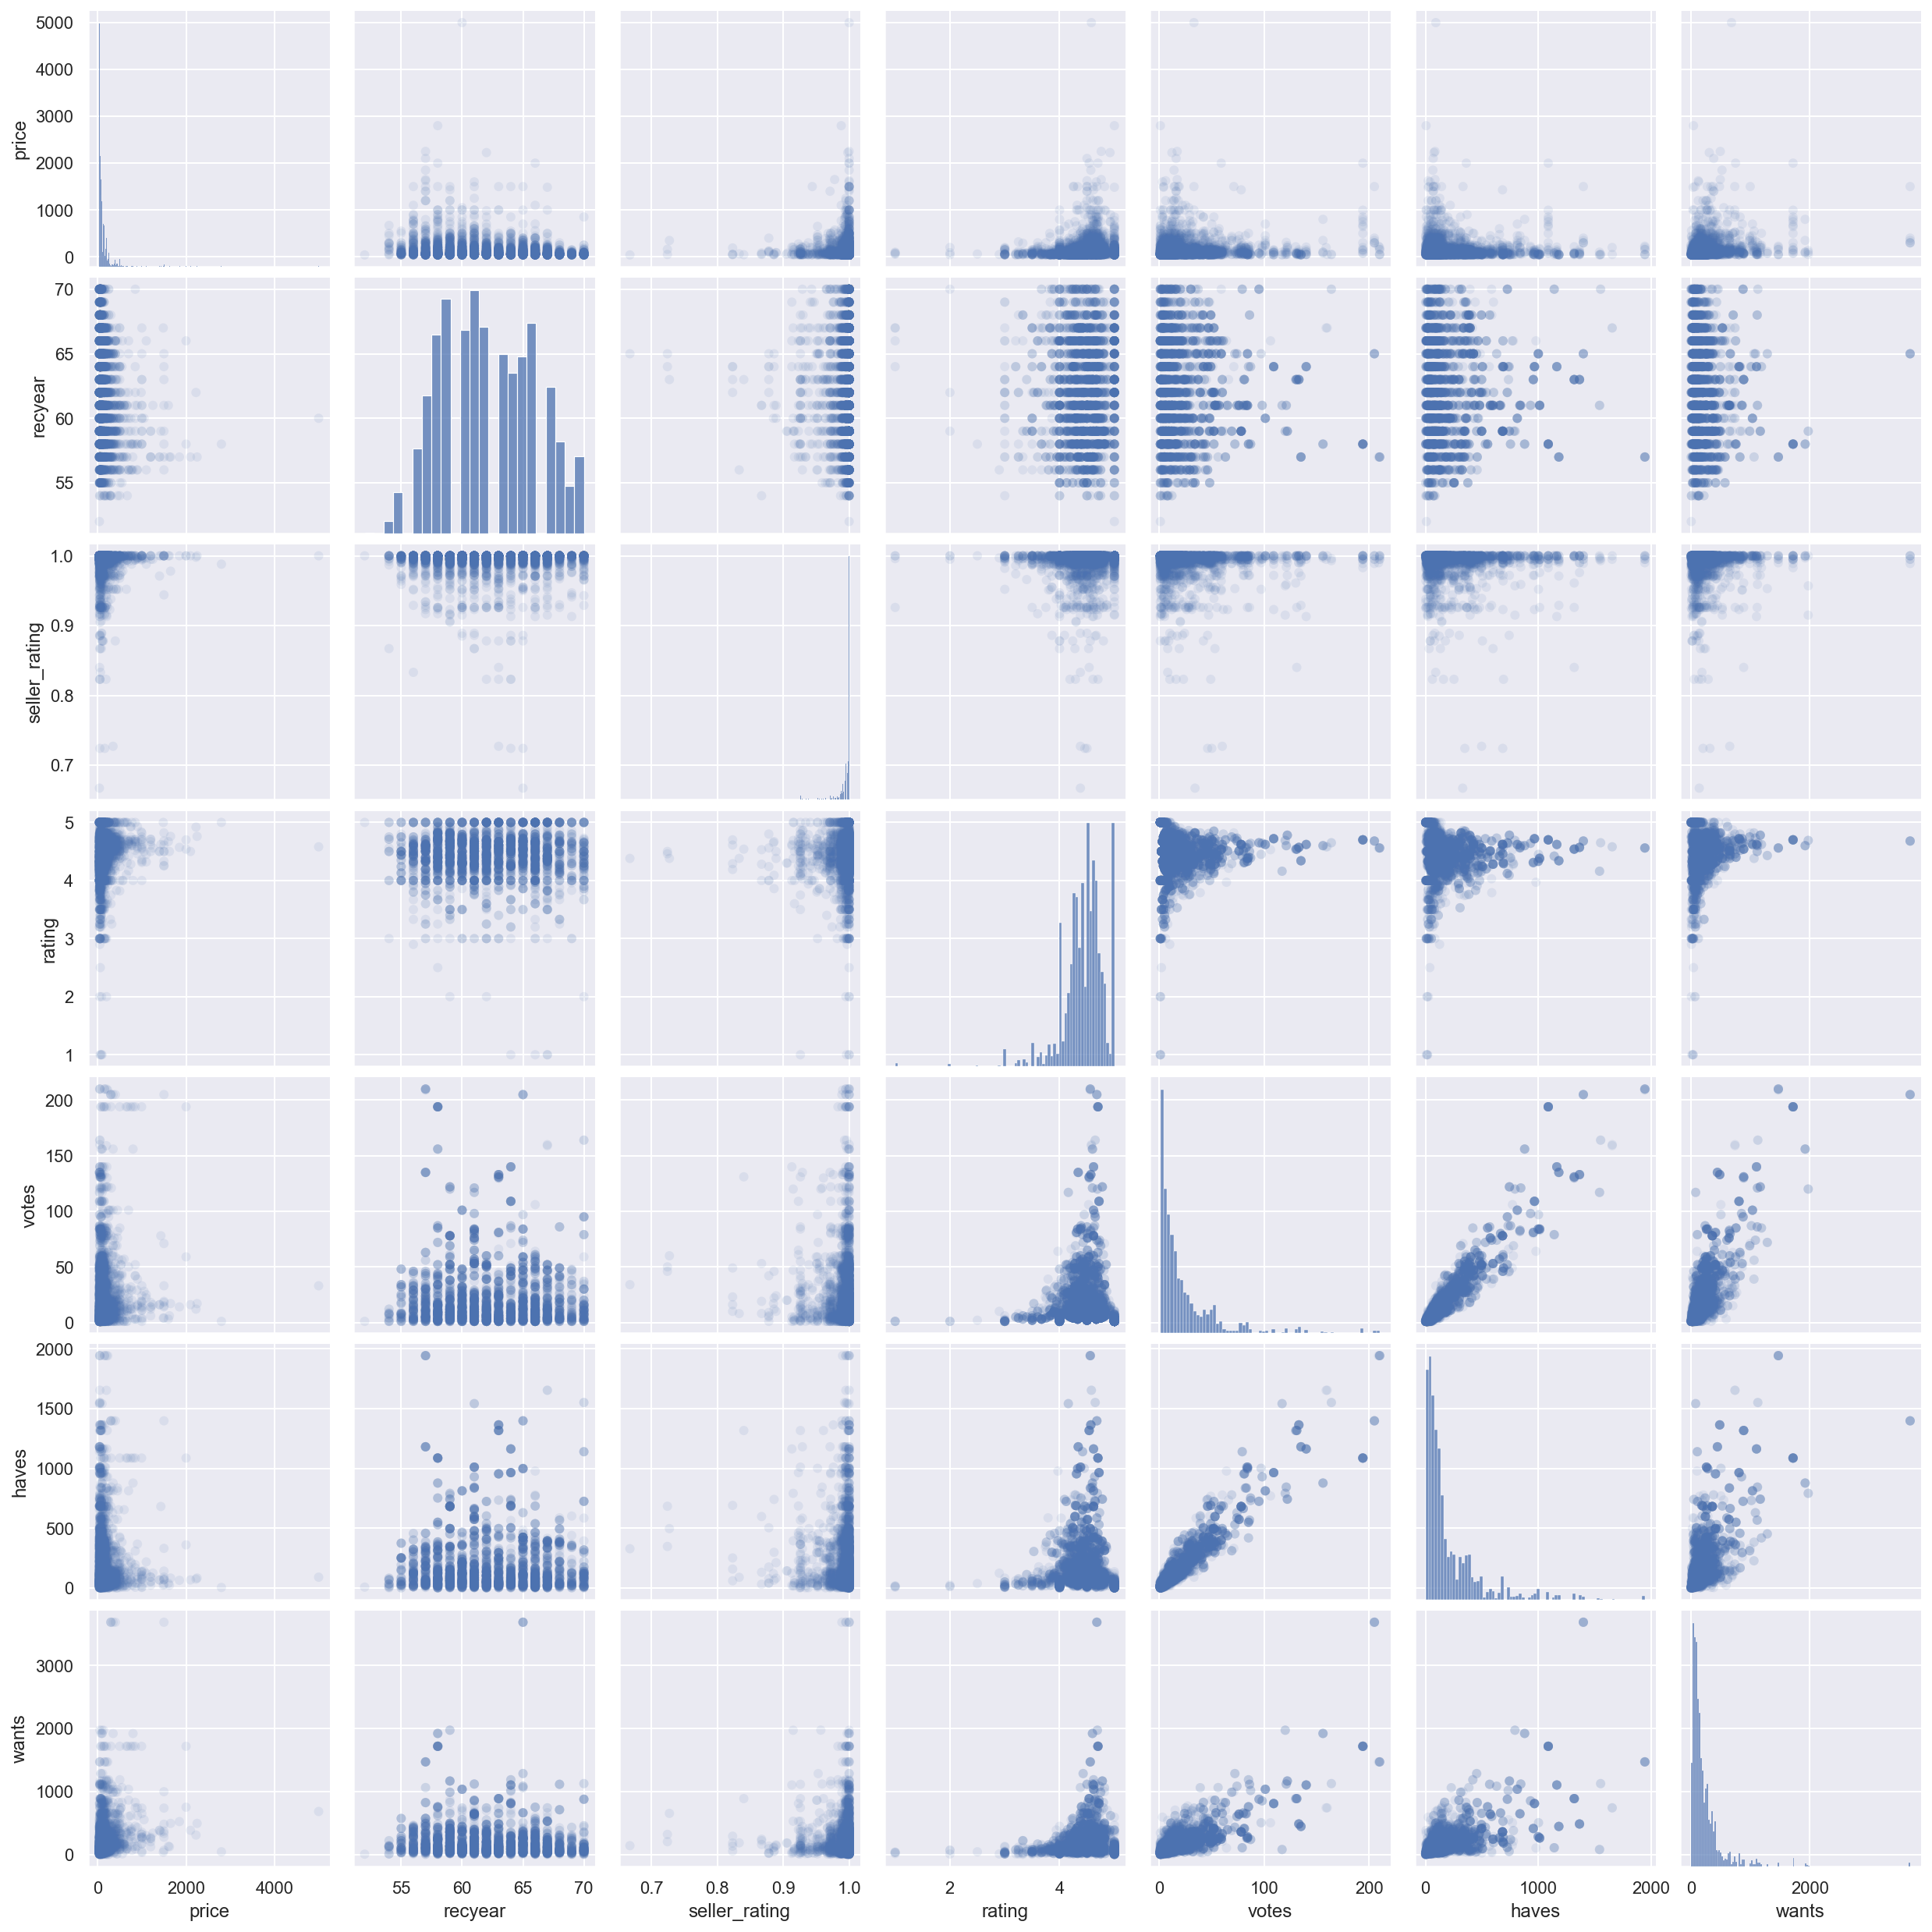

In [866]:
sns.pairplot(df_pair,plot_kws=dict(alpha=.1,edgecolor='none'))

**Observations**
- votes, haves and wants may be colinear with price
- there are some peaks in years that have higher values
- most seller ratings are high, the highest demand the highest price
- some positive correlation with rating and price

**Check for correlated variables**

In [980]:
df_corr = df.corr()
df_corr

,fpress,spress,tpress,original,rare,dgroove,sealed,price,recyear,seller_rating,rating,votes,haves,wants
fpress,1.000000,0.219912,0.240259,0.273417,-0.018580,0.285735,-0.010379,0.093806,-0.051990,0.020500,0.082655,0.170477,0.117027,0.181744
spress,0.219912,1.000000,0.217309,-0.021937,-0.015100,0.053411,-0.005028,0.012446,-0.058652,0.031238,0.062606,0.011022,-0.003506,0.038620
tpress,0.240259,0.217309,1.000000,0.118189,-0.016915,0.343292,-0.005632,0.114408,-0.191192,-0.005374,0.111458,0.046082,0.005552,0.065135
original,0.273417,-0.021937,0.118189,1.000000,-0.024095,0.221106,0.035392,0.047935,-0.017558,0.018065,0.016696,0.174627,0.124887,0.134945
rare,-0.018580,-0.015100,-0.016915,-0.024095,1.000000,-0.015231,-0.000853,-0.010850,0.048217,-0.004880,-0.023197,-0.013100,-0.009595,-0.024191
dgroove,0.285735,0.053411,0.343292,0.221106,-0.015231,1.000000,-0.009458,0.110131,-0.322962,0.030547,0.077620,0.147380,0.086962,0.149651
sealed,-0.010379,-0.005028,-0.005632,0.035392,-0.000853,-0.009458,1.000000,-0.007663,0.012614,0.004504,0.025094,-0.012504,-0.013213,-0.012770
price,0.093806,0.012446,0.114408,0.047935,-0.010850,0.110131,-0.007663,1.000000,-0.169406,0.025563,0.129380,0.076280,-0.012675,0.232904
recyear,-0.051990,-0.058652,-0.191192,-0.017558,0.048217,-0.322962,0.012614,-0.169406,1.000000,0.002839,0.006199,-0.045885,-0.013419,-0.082925
seller_rating,0.020500,0.031238,-0.005374,0.018065,-0.004880,0.030547,0.004504,0.025563,0.002839,1.000000,0.023156,-0.035235,-0.055431,-0.011284


<AxesSubplot:>

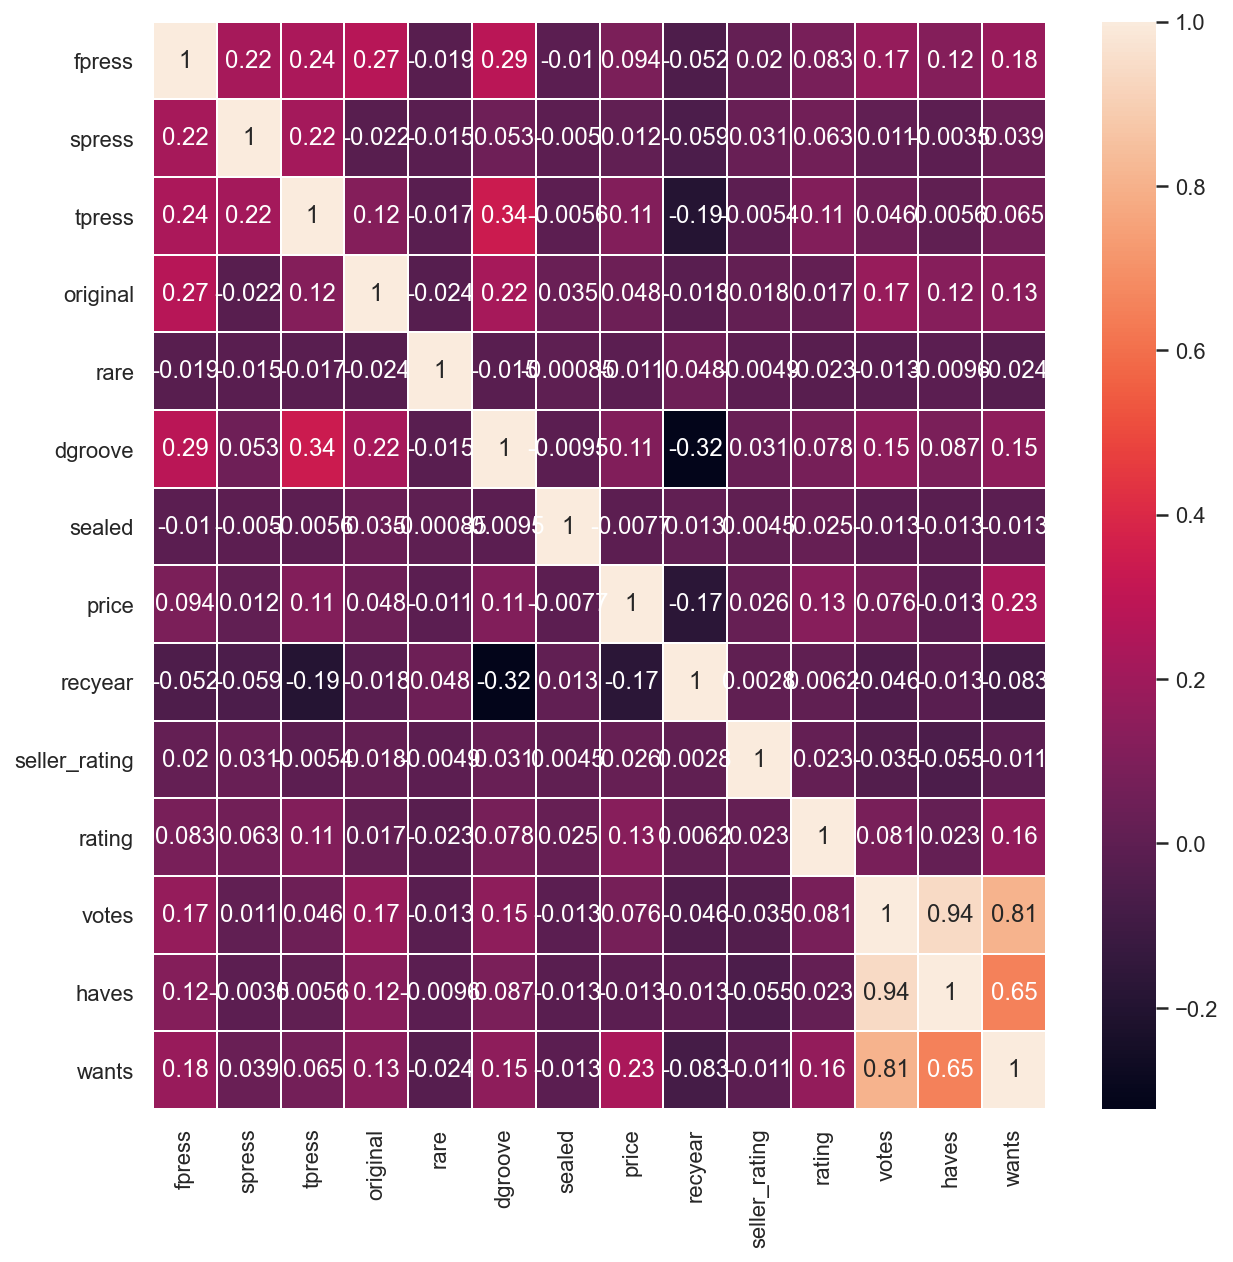

In [913]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_corr, annot=True, linewidths=.5, ax=ax)

**Crosstab Function**

In [1103]:
def xtab(fieldname):
    lab_tab=df[fieldname].value_counts(ascending=False)
    lab_tab2=df[fieldname].value_counts(ascending=False,normalize=True)
    
    print(lab_tab.head(30),lab_tab2.head(30))
    
    # lab_tab = pd.crosstab(index=df["reclabel"],  # Make a crosstab
    #                               columns="count")
    # lab_tab.sort_values('reclabel', ascending=False,inplace=True)

In [914]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

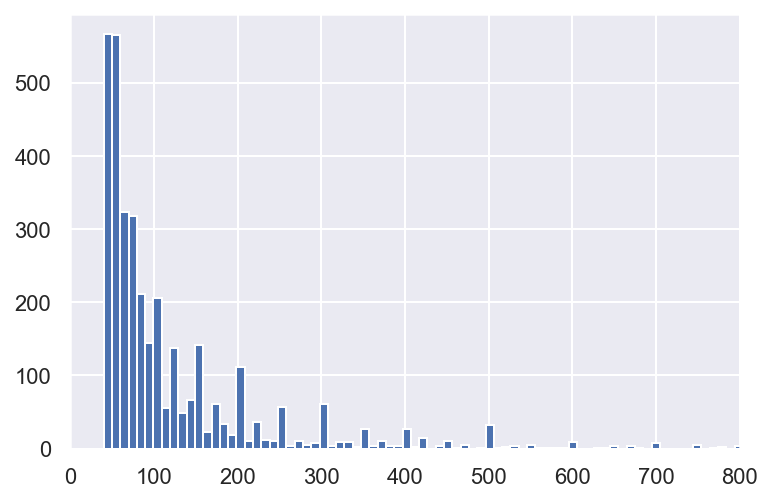

In [915]:
# Price
plt.hist(df['price'], bins =500)
plt.xlim(0,800)
plt.show()

In [1206]:
df.describe()

,fpress,spress,tpress,original,rare,dgroove,sealed,price,recyear,seller_rating,rating,votes,haves,wants,labcount
count,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000
mean,0.275050,0.081749,0.100483,0.184786,0.002555,0.239569,0.000284,139.679012,62.148169,0.992937,4.445200,23.352540,206.279591,219.749077,574.812092
std,0.446603,0.274020,0.300685,0.388179,0.050486,0.426881,0.016848,208.228680,3.810110,0.018942,0.372592,30.126395,260.545680,284.723381,482.583748
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,52.000000,0.667000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,59.000000,0.994000,4.280000,5.000000,50.000000,70.000000,161.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.000000,62.000000,0.999000,4.500000,12.000000,111.000000,134.000000,357.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,149.645000,65.000000,1.000000,4.670000,29.000000,255.000000,268.000000,1203.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000,70.000000,1.000000,5.000000,210.000000,1943.000000,3685.000000,1203.000000


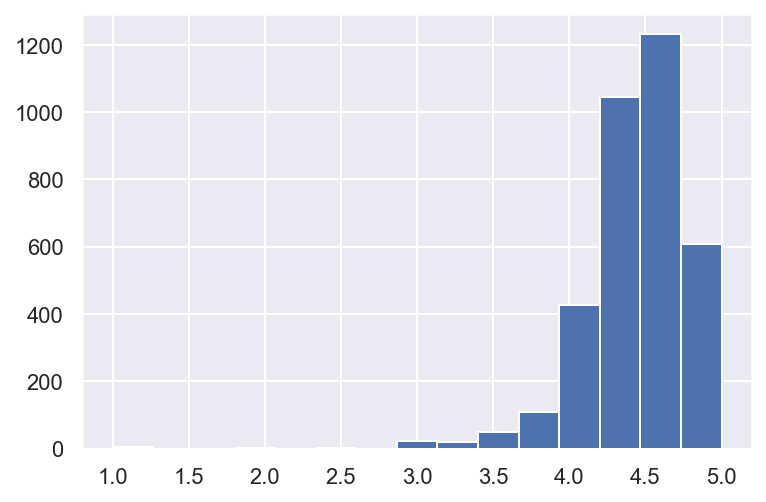

In [916]:
# rating
plt.hist(df['rating'], bins =15)
#plt.xlim(0,800)
plt.show()

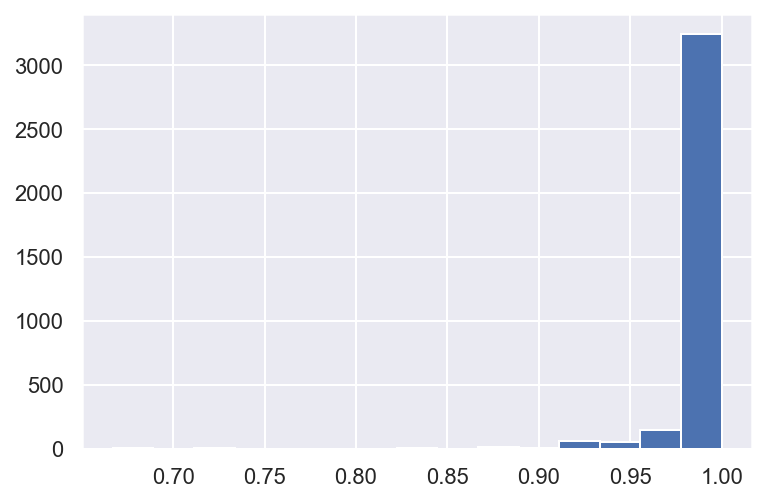

In [917]:
# seller rating
plt.hist(df['seller_rating'], bins =15)
#plt.xlim(0,800)
plt.show()

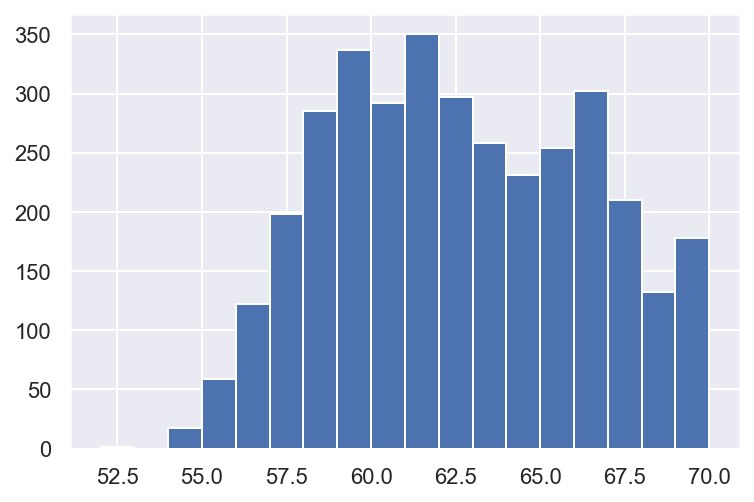

In [918]:
# record year
plt.hist(df['recyear'], bins =18)
#plt.xlim(0,800)
plt.show()

**Maybe we can take the age of album instead of year** <br>
**or convert to categorical**


**Bin Labels: Group < 100 to OTher**

In [1107]:
df['labcount']=df.groupby(["reclabel"])["reclabel"].transform('count')
df.loc[df['labcount'] > 10, 'reclabel2'] = df['reclabel']
df.loc[df['labcount'] <=10,   'reclabel2'] = 'Other'
df.head(2)

,Label,Country,Notes,Genre,Release_Date,Style,notes,fpress,spress,tpress,...,recyear,sleeve_cond_abbr,media_cond_abbr,seller_rating,rating,votes,haves,wants,labcount,reclabel2
0,Blue Note – BLP 1502,US,"Recorded at the WOR Studios, NYC, on May 9, 19...",Jazz,Feb 1956,"Hard Bop, Bop","recorded at the wor studios, nyc, on may 9, 19...",1,0,0,...,56.0,VG,VG+,0.988,4.32,25.0,219.0,301.0,1203,Blue Note
1,Blue Note – BLP 1567,US,"Recorded on June 16, 1957.",Jazz,1957,Hard Bop,"recorded on june 16, 1957.",0,0,0,...,57.0,VG,VG,1.000,4.50,16.0,68.0,385.0,1203,Blue Note
2,Blue Note – BLP 1508,US,"Recorded live on November 23, 1955.\n\n1st ori...",Jazz,May 1956,Hard Bop,"recorded live on november 23, 1955.\n\n1st ori...",1,0,0,...,56.0,VG+,NM or M-,0.988,4.62,29.0,206.0,411.0,1203,Blue Note
3,Blue Note – BLP 1549,US,"Recorded on March 3, 1957.\n\nThe 1st original...",Jazz,May 1957,Hard Bop,"recorded on march 3, 1957.\n\nthe 1st original...",1,0,1,...,57.0,VG,VG+,0.978,4.76,17.0,84.0,495.0,1203,Blue Note
5,New Jazz – PRLP 8205,US,"Original Copy: Deep groove, purple label",Jazz,1961,Hard Bop,"original copy: deep groove, purple label",0,0,0,...,61.0,NM or M-,VG+,0.994,4.60,10.0,34.0,131.0,75,New Jazz


In [1093]:
# record label
xtab('reclabel')

Blue Note                  1203
Prestige                    555
Columbia                    357
Riverside Records           247
Impulse!                    188
Atlantic                    161
New Jazz                     75
Verve Records                56
Vee Jay Records              51
Contemporary Records         37
RCA Victor                   34
Jazzland                     28
Argo (6)                     27
United Artists Records       20
Epic                         19
EmArcy                       19
Pacific Jazz                 19
JAZZLAND                     18
CBS                          16
Jazz Workshop                16
Capitol Records              15
Mercury                      15
Fontana                      13
Savoy Records                12
Trova                        11
Time Records (3)             10
Fantasy                      10
United Artists Jazz           9
Candid                        9
World Pacific Records         9
Name: reclabel, dtype: int64 Blue Note  

In [1108]:
# record label
xtab('reclabel2')

Blue Note                  1203
Prestige                    555
Columbia                    357
Other                       311
Riverside Records           247
Impulse!                    188
Atlantic                    161
New Jazz                     75
Verve Records                56
Vee Jay Records              51
Contemporary Records         37
RCA Victor                   34
Jazzland                     28
Argo (6)                     27
United Artists Records       20
Pacific Jazz                 19
EmArcy                       19
Epic                         19
JAZZLAND                     18
Jazz Workshop                16
CBS                          16
Capitol Records              15
Mercury                      15
Fontana                      13
Savoy Records                12
Trova                        11
Name: reclabel2, dtype: int64 Blue Note                  0.341470
Prestige                   0.157536
Columbia                   0.101334
Other                      0.0

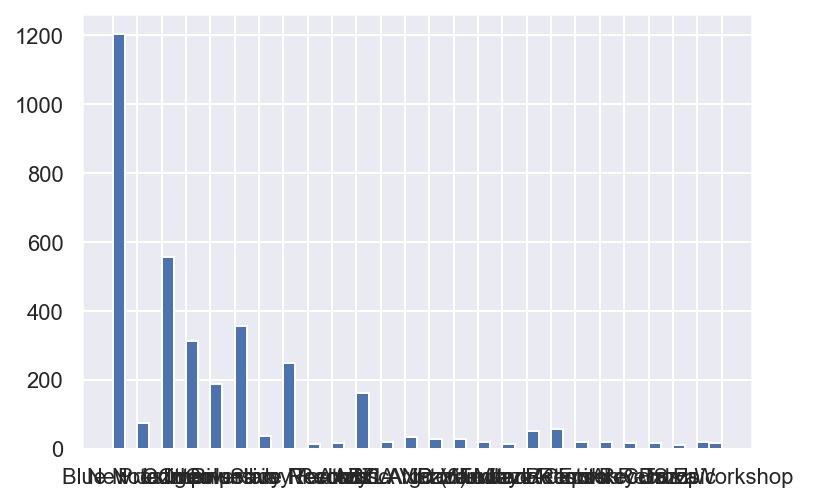

In [1110]:
# hist of record label
plt.hist(df['reclabel2'], bins =50)
#plt.xlim(0,800)
plt.show()

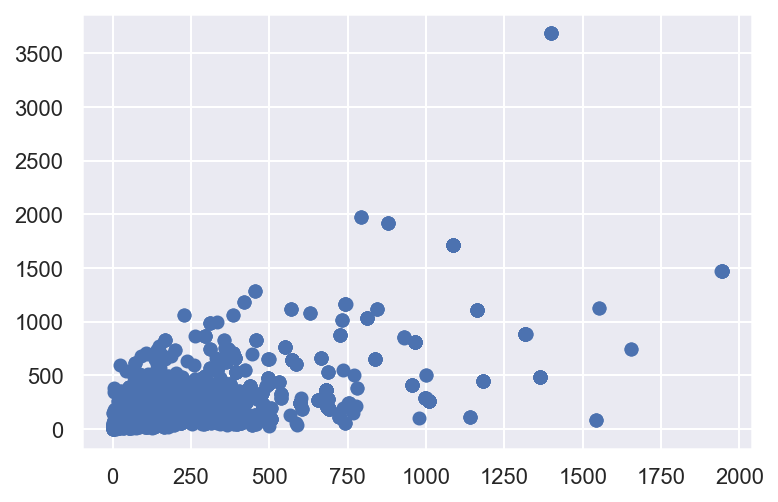

In [887]:
# haves / wants
plt.scatter(df['haves'],df['wants'])
plt.show()

In [1074]:
# country
xtab('Country')

US                                  3321
UK                                    56
Japan                                 36
Canada                                28
Germany                               19
France                                15
Argentina                             13
Netherlands                            5
Sweden                                 4
USA & Europe                           4
Poland                                 4
Czechoslovakia                         3
Denmark                                2
Spain                                  2
German Democratic Republic (GDR)       2
South Africa                           1
Italy                                  1
Taiwan                                 1
Switzerland                            1
Yugoslavia                             1
Name: Country, dtype: int64


**Country: may need to drop**

In [1075]:
# Genre
xtab('Genre')

Jazz                            3392
Jazz, Blues                       52
Jazz, Stage & Screen              29
Jazz, Funk / Soul                 21
Jazz, Latin                       13
Jazz, Funk / Soul, Blues           7
Jazz, Pop                          3
Jazz, Folk, World, & Country       3
Jazz, Non-Music                    2
Jazz, Pop, Stage & Screen          1
Name: Genre, dtype: int64


**Genre: drop**

In [1076]:
# Media/sleeve
xtab('media_cond_abbr')

VG+         1460
VG           922
NM or M-     721
G+           228
M            110
G             65
F             14
P              3
Name: media_cond_abbr, dtype: int64


In [1077]:
# Media/sleeve
xtab('sleeve_cond_abbr')

VG+         1539
VG          1004
NM or M-     432
G+           303
G            122
M             55
F             47
P             21
Name: sleeve_cond_abbr, dtype: int64


In [1199]:
xtab('dgroove')
#'fpress','spress','tpress','original','sealed','rare'

0    2679
1     844
Name: dgroove, dtype: int64 0    0.760431
1    0.239569
Name: dgroove, dtype: float64


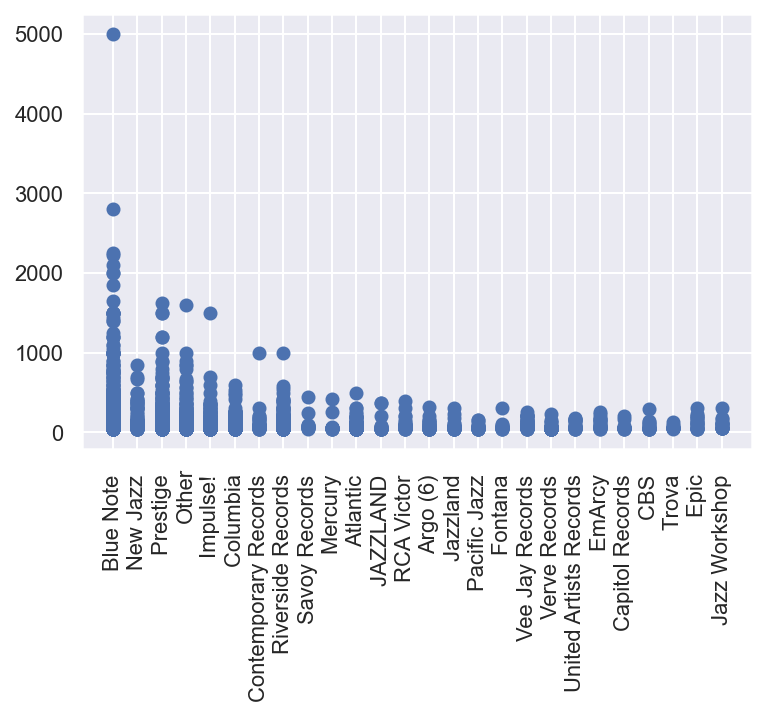

In [1211]:
# hist of record label
plt.scatter(df['reclabel2'],df['price'])
#plt.xlim(0,800)
plt.xticks(rotation=90)
plt.show()

**Instead of using both features separately, combine into one feature**

<br>

### 2. Split Train/Val vs. Test: hold 20% for Test DF

**Drop cat vars that are not necessary**

In [1032]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3523 entries, 0 to 4084
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Label             3523 non-null   object 
 1   Country           3523 non-null   object 
 2   Notes             3523 non-null   object 
 3   Genre             3523 non-null   object 
 4   Release_Date      3523 non-null   object 
 5   Style             3523 non-null   object 
 6   notes             3523 non-null   object 
 7   fpress            3523 non-null   int64  
 8   spress            3523 non-null   int64  
 9   tpress            3523 non-null   int64  
 10  original          3523 non-null   int64  
 11  rare              3523 non-null   int64  
 12  dgroove           3523 non-null   int64  
 13  sealed            3523 non-null   int64  
 14  price             3523 non-null   float64
 15  artist            3523 non-null   object 
 16  album             3523 non-null   object 


In [1111]:
# DRop other categorical vars that may not be useful for modeling
df2=df.drop(['reclabel','notes','Notes','Country','Label','Genre','Release_Date','Style','artist','album','labcount'], axis=1 ) #, inplace=True)
print(df2.columns)

Index(['fpress', 'spress', 'tpress', 'original', 'rare', 'dgroove', 'sealed',
       'price', 'recyear', 'sleeve_cond_abbr', 'media_cond_abbr',
       'seller_rating', 'rating', 'votes', 'haves', 'wants', 'reclabel2'],
      dtype='object')


<br>

### 3. Train vs. Test Split (80/20)

In [1112]:
X , y = df2.drop('price',axis=1), df2['price']
print(X.columns)
print(X.shape,y.shape)

# hold out 20% of the data for final testing (as array below)
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)

Index(['fpress', 'spress', 'tpress', 'original', 'rare', 'dgroove', 'sealed',
       'recyear', 'sleeve_cond_abbr', 'media_cond_abbr', 'seller_rating',
       'rating', 'votes', 'haves', 'wants', 'reclabel2'],
      dtype='object')
(3523, 16) (3523,)


In [1083]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

### 4. Linear Regression - KF CV (Apply pipeline to crossval and transform)

In [1113]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['sleeve_cond_abbr', 'media_cond_abbr','reclabel2']),
    remainder='passthrough')
lr = LinearRegression() 

In [1114]:
pipe = make_pipeline(column_trans, lr)

**The above does the 5 fold splits and then will run the pipeline. therefore must be done on training set**

In [1115]:
cross_val_score(pipe, X=X_, y=y_, cv=5).mean()

0.22526848193272503

### 4b. Add polynomial

In [1116]:
X2 = X_.copy()

X2['seller_rating2'] = X2['seller_rating'] ** 2
X2['rating2'] = X2['rating'] ** 2

In [1117]:
cross_val_score(pipe, X=X2, y=y_, cv=5).mean()

0.2256334364920896

### 4c. Drop vars

In [1207]:
X3 = X_.copy()

# haves and votes are somewhat related. the more haves, the more votes 
#X3['have_x_vote'] = X3['haves'] * X3['votes']

# division interaction
#X3['want_over_have'] = X3['wants'] / X3['haves']
X3.drop(['dgroove','fpress','spress','tpress','original','sealed','rare'],axis=1,inplace=True)

In [1208]:
cross_val_score(pipe, X=X3, y=y_, cv=5).mean()

0.23111343252626684

**Try standardizing and onehot**

In [ ]:
['fpress', 'spress', 'tpress', 'original', 'rare', 'dgroove', 'sealed',
       'recyear', 'sleeve_cond_abbr', 'media_cond_abbr', 'seller_rating',
       'rating', 'votes', 'haves', 'wants']

In [1053]:
numeric_features = ['seller_rating','rating', 'votes', 'haves', 'wants','recyear']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mode')),
    ('scaler', StandardScaler())])

categorical_features = ['sleeve_cond_abbr', 'media_cond_abbr']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_vall, y_train, y_val = train_test_split(X_, y_, test_size=0.2,
                                                    random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_val, y_val))

ValueError: A given column is not a column of the dataframe

**if you have a new model to fit use below**

In [ ]:
pipe.fit(X_,y_)

In [ ]:
# New data example
X_new = X_sample(5, random_state=99)

In [ ]:
pipe.predict(X_new)

<br>

### 4. Simple Linear Model (training+validation set only)
- X,Y are full DF (transformed)

**ALT METHOD: Split data into TRAIN/VAL vs. TEST** <br>
**Apply Cont/Cat Transformations on Training set**

In [835]:
from sklearn.model_selection import KFold

X , y = df.drop('price',axis=1), df['price']
print(X.columns)

# keep as DF in case (set aside)
#X_df , y_df = df.drop('price',axis=1), df['price']

# hold out 20% of the data for final testing (as array below)
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# As DF for Train/Val (PRE TRANSFORM)
#X_dfmod, X_testdf, y_dfmod, y_testdf = train_test_split(X,y,test_size=.2,random_state=42)

# one hot encode categoricals (Training)
X_ = pd.get_dummies(X_,drop_first=True)

# keep as DF in case
#X_ohe_df = pd.get_dummies(X_,drop_first=True)
print(X_.columns,type(X_))
#print(type(X_))
# Continuous Standardize
#scaler = StandardScaler()    
#X_ = scaler.fit_transform(X_.values)
print(type(X_))

#this helps with the way kf will generate indices below
#X_, y_ = np.array(X_), np.array(y_)
X_kf, y_kf = np.array(X_), np.array(y_)

Index(['fpress', 'spress', 'tpress', 'original', 'rare', 'dgroove', 'sealed',
       'recyear', 'sleeve_cond_abbr', 'media_cond_abbr', 'seller_rating',
       'rating', 'votes', 'haves', 'wants'],
      dtype='object')
Index(['fpress', 'spress', 'tpress', 'original', 'rare', 'dgroove', 'sealed',
       'recyear', 'seller_rating', 'rating', 'votes', 'haves', 'wants',
       'sleeve_cond_abbr_G', 'sleeve_cond_abbr_G+', 'sleeve_cond_abbr_M',
       'sleeve_cond_abbr_NM or M-', 'sleeve_cond_abbr_P',
       'sleeve_cond_abbr_VG', 'sleeve_cond_abbr_VG+', 'media_cond_abbr_G',
       'media_cond_abbr_G+', 'media_cond_abbr_M', 'media_cond_abbr_NM or M-',
       'media_cond_abbr_P', 'media_cond_abbr_VG', 'media_cond_abbr_VG+'],
      dtype='object') <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


**DF definitions:**
- **X_ :** Training set (80%) on ALL X columns (cats,cont)
- **X_test :** Test set (20%) on ALL x columns
- **y_ :** Training set (80%) on y (price)
- **y_test:** Test set (20%) on y (price)
- **X :** Full DF, All x columns (cats, cont)
- **y :** Full DF, All y (price)

#### Setting up for modeling and building a baseline:

Now that we have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a **train/validation split** before we fit and score the model. 

Since we'll be repeatedly splitting X, y into the same train/val partitions and fitting/scoring new models as we update our feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

In [836]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    '''
     preprocessing 
    '''
    # both one hot and continous go here. if you have issues, use iloc.
    
    #scaler = StandardScaler()    
    #X_train = scaler.fit_transform(X_train.values)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    
    print('\nValidation R^2 score was:', val_score)
    #print(X.columns, lr_model.coef_)
    
    # needed to flatten the array
    coefs=lr_model.coef_.flatten()
    #X_cols= X.columns #flatten()
    
    print('Feature coefficient results: \n')
    
    #print(list(zip(lr_model.coef_, X.columns)))    
    
    #for feature, coef in zip(X.columns, coefs):                
    for feature, coef in zip(X_df.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
        #list(map('{:.2f}%'.format,x))

In [837]:
split_and_validate(X_,y_)


Validation R^2 score was: 0.1769182877633314
Feature coefficient results: 

fpress : 17.65
spress : -19.36
tpress : 54.50
original : 5.90
rare : 37.85
dgroove : 18.08
sealed : -0.00
recyear : -8.58
sleeve_cond_abbr : 163.93
media_cond_abbr : 43.98
seller_rating : -0.06
rating : -0.21
votes : 0.31
haves : 27.73
wants : 13.44


### 4b. Add polynomial

In [857]:
X2 = X_.copy()

X2['seller_rating2'] = X2['seller_rating'] ** 2
X2['rating2'] = X2['rating'] ** 2

In [858]:
split_and_validate(X2,y_)


Validation R^2 score was: 0.17775621605821867
Feature coefficient results: 

fpress : 17.66
spress : -20.02
tpress : 54.44
original : 6.00
rare : 38.06
dgroove : 17.89
sealed : 0.00
recyear : -8.64
sleeve_cond_abbr : -1955.17
media_cond_abbr : -6.41
seller_rating : -0.06
rating : -0.21
votes : 0.31
haves : 27.95
wants : 13.06


### 4c. Add interaction

In [859]:
X3 = X_.copy()

# multiplicative interaction
X3['rate_x_vote'] = X3['rating'] * X3['votes']

# division interaction
X3['want_over_have'] = X3['wants'] / X3['haves']

In [860]:
split_and_validate(X3,y_)


Validation R^2 score was: 0.18203754509095083
Feature coefficient results: 

fpress : 16.61
spress : -15.66
tpress : 56.11
original : 5.85
rare : 31.76
dgroove : 19.41
sealed : -0.00
recyear : -8.33
sleeve_cond_abbr : 140.04
media_cond_abbr : 45.19
seller_rating : 8.13
rating : -0.24
votes : 0.29
haves : 24.60
wants : 11.77


<br>

### 5. Simple Linear Model (Cross Validation)

#### Setting up for modeling and building a baseline:

In [861]:
#run the CV
# use the X,y KF arrays

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(X_kf,y_kf):
    
    # cc. this splits your training 80% and val 20% through n iterations
    # none of type int64 (error) resolved using iloc
    X_train, y_train = X_.iloc[train_ind], y_.iloc[train_ind]    
    X_val, y_val = X_.iloc[val_ind], y_.iloc[val_ind] 
    
    '''
     cc. preprocessing (standardize, one hot) -on TRAINING
     start with nums, copy array, apply one hot, run model
     right now is done on training + Val sets
    '''
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train.values)
    
    
    
    #simple linear regression
    lm = LinearRegression()

    # cc. this runs a linear model on trainign to obtain coeffs
    lm.fit(X_train, y_train)
    
    # cc. this takes the coeffs of training and applies to model on validation
    # we only output the r2 scores of the validation model here
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))
    
    '''
    Obtain the coeff per features
    '''
    #needed to flatten the array
    coefs=lm.coef_.flatten()
    
    print('Feature coefficient results: \n')
    
    for feature, coef in zip(X_.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
    
    '''
    Print the R^2 scores and mean scores
    '''
    
print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')


Feature coefficient results: 

fpress : 17.65
spress : -19.36
tpress : 54.50
original : 5.90
rare : 37.85
dgroove : 18.08
sealed : -0.00
recyear : -8.58
seller_rating : 163.93
rating : 43.98
votes : -0.06
haves : -0.21
wants : 0.31
sleeve_cond_abbr_G : 27.73
sleeve_cond_abbr_G+ : 13.44
sleeve_cond_abbr_M : 102.02
sleeve_cond_abbr_NM or M- : 68.83
sleeve_cond_abbr_P : 5.81
sleeve_cond_abbr_VG : 47.76
sleeve_cond_abbr_VG+ : 45.99
media_cond_abbr_G : 49.98
media_cond_abbr_G+ : 57.38
media_cond_abbr_M : 201.82
media_cond_abbr_NM or M- : 182.40
media_cond_abbr_P : -36.84
media_cond_abbr_VG : 107.91
media_cond_abbr_VG+ : 152.34
Feature coefficient results: 

fpress : 27.11
spress : -24.37
tpress : 46.91
original : 4.67
rare : 17.25
dgroove : 19.90
sealed : -169.64
recyear : -10.05
seller_rating : 214.14
rating : 45.87
votes : -0.09
haves : -0.25
wants : 0.35
sleeve_cond_abbr_G : 45.78
sleeve_cond_abbr_G+ : 3.21
sleeve_cond_abbr_M : 74.44
sleeve_cond_abbr_NM or M- : 65.04
sleeve_cond_abbr_P :

### 5b. Polynomial model

In [ ]:
#run the CV
# use the X,y KF arrays

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(X_kf,y_kf):
    
    # cc. this splits your training 80% and val 20% through n iterations
    # none of type int64 (error) resolved using iloc
    X_train, y_train = X_.iloc[train_ind], y_.iloc[train_ind]    
    X_val, y_val = X_.iloc[val_ind], y_.iloc[val_ind] 
    
    '''
     cc. preprocessing (standardize, one hot) -on TRAINING
     start with nums, copy array, apply one hot, run model
     right now is done on training + Val sets
    '''
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train.values)
    
    
    
    ''' 
    #poly with degree 2
    poly = PolynomialFeatures(degree=2)
    
    
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    lm_poly = LinearRegression()
    
    lm_poly.fit(X_train_poly, y_train)
    cv_lm_poly_r2s.append(round(lm_poly.score(X_val_poly, y_val), 3))
    
print('Poly scores: ', cv_lm_poly_r2s, '\n')

print(f'Poly mean cv r^2: {np.mean(cv_lm_poly_r2s):.3f} +- {np.std(cv_lm_poly_r2s):.3f}')
    '''
    
    
    
    #simple linear regression
    lm = LinearRegression()

    # cc. this runs a linear model on trainign to obtain coeffs
    lm.fit(X_train, y_train)
    
    # cc. this takes the coeffs of training and applies to model on validation
    # we only output the r2 scores of the validation model here
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))
    
    '''
    Obtain the coeff per features
    '''
    #needed to flatten the array
    coefs=lm.coef_.flatten()
    
    print('Feature coefficient results: \n')
    
    for feature, coef in zip(X_.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
    
    '''
    Print the R^2 scores and mean scores
    '''
    
print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')


### 6. Lasso / Ridge Regression

In [403]:
X_n = X_.select_dtypes(exclude=['object']).copy()

In [154]:
#Separate our features from our target
# X = df_recn.loc[:,['recyear','seller_rating','rating','votes','haves','wants']]
# y = df_recn.loc[:,['price']]

In [404]:
X_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2991 entries, 512 to 3448
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recyear        2991 non-null   int64  
 1   seller_rating  2991 non-null   float64
 2   rating         2991 non-null   float64
 3   votes          2991 non-null   float64
 4   haves          2991 non-null   int64  
 5   wants          2991 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 163.6 KB


### 3. Start with numerics (training+validation set only)
- X,Y are full DF and unnecessary
- anything with 'test' is unnecessary at this step
- that leaves the '_' X and y

In [403]:
X_n = X_.select_dtypes(exclude=['object']).copy()

In [154]:
#Separate our features from our target
# X = df_recn.loc[:,['recyear','seller_rating','rating','votes','haves','wants']]
# y = df_recn.loc[:,['price']]

In [404]:
X_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2991 entries, 512 to 3448
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recyear        2991 non-null   int64  
 1   seller_rating  2991 non-null   float64
 2   rating         2991 non-null   float64
 3   votes          2991 non-null   float64
 4   haves          2991 non-null   int64  
 5   wants          2991 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 163.6 KB


**Observations**
- votes, haves and wants may be colinear with price
- there are some peaks in years that have higher values
- most seller ratings are high, the highest demand the highest price
- some positive correlation with rating and price

#### Setting up for modeling and building a baseline:

Now that we have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a **train/validation split** before we fit and score the model. 

Since we'll be repeatedly splitting X, y into the same train/val partitions and fitting/scoring new models as we update our feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

In [557]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    '''
     preprocessing 
    '''
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    
    print('\nValidation R^2 score was:', val_score)
    #print(X.columns, lr_model.coef_)
    
    # needed to flatten the array
    coefs=lr_model.coef_.flatten()
    #X_cols= X.columns #flatten()
    
    print('Feature coefficient results: \n')
    
    #print(list(zip(lr_model.coef_, X.columns)))    
    
    #for feature, coef in zip(X.columns, coefs):                
    for feature, coef in zip(X_df.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
        #list(map('{:.2f}%'.format,x))

In [558]:
split_and_validate(X_,y_)


Validation R^2 score was: 0.17531005376623376
Feature coefficient results: 

recyear : -37.33
sleeve_cond_abbr : 3.90
media_cond_abbr : 16.43
seller_rating : 30.76
rating : -82.79
votes : 81.00
haves : 9.33
wants : 2.29


## 2. Basic feature engineering: adding polynomial terms

One of the first things that we looked for in the pairplot was evidence about the relationship between each feature and the target. In certain features like _'Overall Qual'_ and _'Gr Liv Qual'_, we notice an upward-curved relationship rather than a simple linear correspondence. This suggests that we should add quadratic **polynomial terms or transformations** for those features, allowing us to express that non-linear relationship while still using linear regression as our model.

Luckily, pandas makes it quite easy to quickly add those square terms as additional features to our original feature set. We'll do so and evaluate our model again below.

As we add to our baseline set of features, we'll create a copy of the latest benchmark so that we can continue to store our older feature sets. **Note that you should be very careful about this in practice**, as it means that we are saving several redundant copies of the data: it's often better to continuously override the original feature set in order to save RAM.

In [284]:
X2 = X_n.copy()

X2['seller_rating2'] = X2['seller_rating'] ** 2
X2['rating2'] = X2['rating'] ** 2

split_and_validate(X2, y_)


Validation R^2 score was: 0.05021227454168209
Feature coefficient results: 

recyear : -6.94
seller_rating : -2522.46
rating : -37.85
votes : 0.05
haves : -0.22
wants : 0.32
seller_rating2 : 1528.65
rating2 : 8.83


As we might expect, adding appropriate square terms allows our model to do a significantly better job (+.05 R^2) capturing certain feature-target relationships that are closer to quadratic than linear. If we saw higher-order curve relationships, we could try adding higher degree polynomial terms as well.

**Note**: feature transformations are not limited to polynomial terms and can also include log and square root transforms among others. Follow your instinct based on what you see in feature-target plots, and validate!

**CC: Adding a polynomial doesn't add much**

## 3. Basic feature engineering: adding interaction terms

With our current feature set, each feature value has no influence over how the model views other features' values. Each feature is treated as a completely independent quantity. However, there may easily be **interaction effects** present, in which the impact of one feature may dependent on the current value of a different feature.

For example, there may be a higher premium for increasing _'Overall Qual'_ for houses that were built more recently. If such a premium or a similar effect exists, a feature that multiplies _'Overall Qual'_ by _'Year Built'_ can help us capture it.

Another style of interaction term involves feature proprtions: for example, to get at something like quality per square foot we could divide _'Overall Qual'_ by _'Lot Area'_.

Let's try adding both of these interaction terms and see how they impact the model results.

### CC: May have to use your own JUDGEMENT, intuition and domain knowledge for interaction terms
- nothing stops you from running polynomial features, etc.
- nothing stops you from interaction terms

- however - the danger is too many features = overfitting
- therefore - regularization will help with that

- process:
    . feature engineering
    . regularization
    . repeat feedback loop

In [159]:
# Testing why infinite values- was dividing by zero

# np.isnan(X2)
# np.where(np.isnan(X2))
# np.nan_to_num(X2['wants'])

#X2.describe()
#X2.haves.value_counts(sort=False,ascending=False)
#test=round(X2['wants'] / X2['haves'] , 2).astype(float)
# test.describe()

In [285]:
X3 = X2.copy()

# multiplicative interaction
X3['rate_x_vote'] = X3['rating'] * X3['votes']

# division interaction
X3['want_over_have'] = X3['wants'] / X3['haves']

split_and_validate(X3, y_)


Validation R^2 score was: 0.05146882751187509
Feature coefficient results: 

recyear : -7.02
seller_rating : -1873.97
rating : -26.10
votes : 11.73
haves : -0.28
wants : 0.29
seller_rating2 : 1186.45
rating2 : 7.94
rate_x_vote : -2.37
want_over_have : 9.95


## 4. Intermediate feature engineering: categories and features derived from category aggregates 

Incorporating **categorical features** into linear regression models is fairly straightforward: we can create a new feature column for each category value, and fill these columns with 1s and 0s to indicate which category is present for each row. This method is called **dummy variables** or **one-hot-encoding**.

We'll first explore this using the _'House Style'_ feature from the original dataframe. Before going straight to dummy variables, it's a good idea to check category counts to make sure all categories have reasonable representation.

**Categorical conversions:**

- sleeve / media conditions: Can change to ordinal ranks
- artist rankings: Can rank artists based on frequency of list
- reclabel: may need to bin depending
- country: may need to bin
- pressed by: may need to bin
- recoreded at: may need to bin
- style: may or may not use
- notes: if we get notes, parse out keywords and turn into booleans:
    . first, 1st, second, 2nd, original, rare, deep groove

In [286]:
df['sleeve_cond_abbr'].value_counts()

VG+         1640
VG          1047
NM or M-     486
G+           318
G            121
M             58
F             47
P             22
Name: sleeve_cond_abbr, dtype: int64

In [294]:
X4 = X3.copy()

#X4['media_cond_abbr'] = df['media_cond_abbr']
X4[['media_cond_abbr','sleeve_cond_abbr']] = X_[['media_cond_abbr','sleeve_cond_abbr']]

split_and_validate(pd.get_dummies(X4), y_)


Validation R^2 score was: 0.06795202661785438
Feature coefficient results: 

recyear : -10.65
seller_rating : -1261.12
rating : -5.01
votes : 14.86
haves : -0.36
wants : 0.35
seller_rating2 : 871.54
rating2 : 6.84
rate_x_vote : -2.96
want_over_have : 11.09
media_cond_abbr_F : -127.90
media_cond_abbr_G : -86.82
media_cond_abbr_G+ : -40.79
media_cond_abbr_M : 87.77
media_cond_abbr_NM or M- : 75.35
media_cond_abbr_P : -0.00
media_cond_abbr_VG : 22.32
media_cond_abbr_VG+ : 70.07
sleeve_cond_abbr_F : -47.94
sleeve_cond_abbr_G : -4.45
sleeve_cond_abbr_G+ : -47.38
sleeve_cond_abbr_M : 74.46
sleeve_cond_abbr_NM or M- : 53.20
sleeve_cond_abbr_P : -19.24
sleeve_cond_abbr_VG : -10.65
sleeve_cond_abbr_VG+ : 2.01
